###  Prediccion del valor de propiedades en la ciudad de Buenos Aires comparando los modelos Random Forest , KNN and XGBoost ###

In [1]:
# Importo las librerias a utilizar
import numpy as np
import pandas as pd 

from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns  

#from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

#Decission Tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

#Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

#Metricas y evaluacion
import sklearn.metrics as metrics
from sklearn.model_selection import learning_curve

#Gridsearch
from sklearn.model_selection import GridSearchCV

#XGBoost
import xgboost as xgb
from sklearn.metrics import mean_squared_error

#Tabla
from tabulate import tabulate

ModuleNotFoundError: No module named 'sklearn'

### Pre-procesamiento

In [3]:
# Levanto el dataset de Properati

properati_in= pd.read_csv(r"data.csv")

In [4]:
#Renombro las columnas l1, l2 y l3 par identificarlas facilmente
properati_in=properati_in.rename(columns={"l1":"country","l2":"region","l3":"location"})

Analizo el dataset original nuevamente pero ahora utilizando la herramienta pandas_profiling

In [5]:
ProfileReport(properati_in, title= "Analisis macro del dataset")

Summarize dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Variables con valores faltantes
* Bathrooms : 4,9%
* surface_total= 14,9%
* surface_covered= 14,7%
* lat y lon =6.8%

#### Informacion relevante de las variables



Tamaño del dataset actual

In [5]:
properati_in.shape

(146660, 19)

A partir de los analisis realizados en el dataset durante el proyecto 1, en las instancias en las cuales la superficie total es menor que la superficie cubierta, reemplazo su valor por la superficie cubierta ya que seria un valor ilógico si lo mantuviera:

In [6]:
properati_in['surface_total'] = np.where(properati_in['surface_total'] < properati_in['surface_covered'] , properati_in['surface_covered'], properati_in['surface_total'])

properati_in.shape

(146660, 19)

In [7]:
'Cuantos datos faltantes hay en cada columna?'
properati_in.isna().sum()

start_date             0
end_date               0
created_on             0
lat                 9925
lon                 9959
country                0
region                 0
location               0
rooms                  0
bedrooms               0
bathrooms           5957
surface_total      20527
surface_covered    21614
price                  0
currency               0
title                  0
description            0
property_type          0
operation_type         0
dtype: int64

In [8]:
properati_in.describe()

lat            lon          rooms       bedrooms  \
count  136735.000000  136701.000000  146660.000000  146660.000000   
mean      -34.604896     -58.465304       3.079817       1.983240   
std         0.468428       0.486190       1.416352       1.151304   
min       -35.318457    -180.000000       1.000000       0.000000   
25%       -34.627667     -58.504012       2.000000       1.000000   
50%       -34.600943     -58.443262       3.000000       2.000000   
75%       -34.574600     -58.407586       4.000000       3.000000   
max        85.051129     -57.805832      35.000000      15.000000   

           bathrooms  surface_total  surface_covered         price  
count  140703.000000  126133.000000    125046.000000  1.466600e+05  
mean        1.599994     225.114546       112.818011  2.412211e+05  
std         0.889324    2110.099162       916.857584  3.185195e+05  
min         1.000000      10.000000         1.000000  5.500000e+03  
25%         1.000000      52.000000        47.000000  1.110000e+05  
50%         1.000000      79.000000        68.000000  1.660000e+05  
75%         2.000000     140.000000       108.000000  2.650000e+05  
max        14.000000  193549.000000    126062.000000  3.243423e+07

#### Selección de datos

Elijo las features con las cuales seguiré trabajando


In [9]:
# Me quedo con las propiedades de Capital Federal correspondientes a PH, departamento y casa
properati=properati_in[(properati_in.region == 'Capital Federal') & ((properati_in.property_type =='Departamento') | (properati_in.property_type == 'Casa' ) | (properati_in.property_type == 'PH' )) ]

In [10]:
properati= properati.drop(['region','start_date','end_date','created_on','country','currency','title','description','operation_type','location'],axis=1)

In [11]:
properati.head()

lat        lon  rooms  bedrooms  bathrooms  surface_total  \
0 -34.605880 -58.384949    7.0       7.0        2.0          140.0   
1 -34.624056 -58.412110    2.0       1.0        2.0           70.0   
2 -34.593569 -58.427474    2.0       1.0        1.0           45.0   
3 -34.581294 -58.436754    2.0       1.0        1.0           85.0   
5 -34.593779 -58.441239    2.0       1.0        1.0           56.0   

   surface_covered     price property_type  
0            140.0  153000.0  Departamento  
1             58.0  159000.0            PH  
2             45.0  125000.0            PH  
3             50.0  295000.0            PH  
5             56.0  150000.0            PH

## Tratamiento y limpieza de datos

### Encoding - Tratamiento de variables categoricas

In [12]:
properati_clean2= properati.copy(deep=True)

# Realizo un enconding (get dummies) sobre las variables categoricas: region y property_type 

properati_dummies= pd.get_dummies(properati_clean2,prefix=None,columns=['property_type'], drop_first=False)
properati_dummies.head()

lat        lon  rooms  bedrooms  bathrooms  surface_total  \
0 -34.605880 -58.384949    7.0       7.0        2.0          140.0   
1 -34.624056 -58.412110    2.0       1.0        2.0           70.0   
2 -34.593569 -58.427474    2.0       1.0        1.0           45.0   
3 -34.581294 -58.436754    2.0       1.0        1.0           85.0   
5 -34.593779 -58.441239    2.0       1.0        1.0           56.0   

   surface_covered     price  property_type_Casa  property_type_Departamento  \
0            140.0  153000.0                   0                           1   
1             58.0  159000.0                   0                           0   
2             45.0  125000.0                   0                           0   
3             50.0  295000.0                   0                           0   
5             56.0  150000.0                   0                           0   

   property_type_PH  
0                 0  
1                 1  
2                 1  
3                 1  
5                 1

### Tratamiento de outliers

Analizo graficamente los precios de las propiedades:

<AxesSubplot:xlabel='property_type', ylabel='price'>

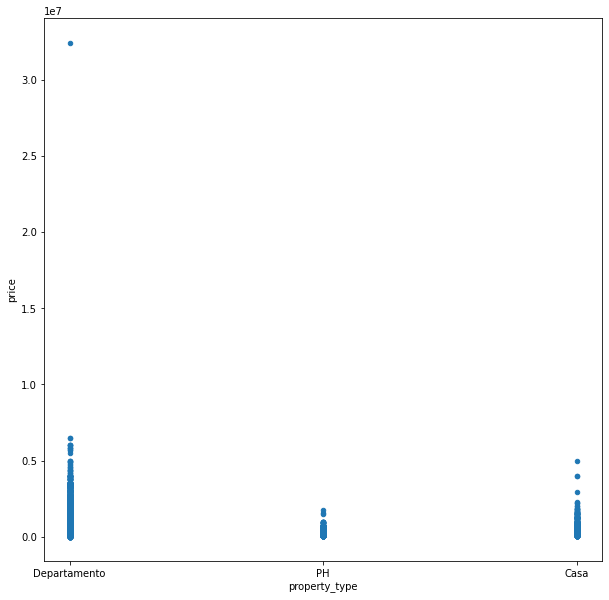

In [13]:
properati.plot.scatter('property_type','price',figsize=(10, 10))

Armo una funcion para remover outliers de mi dataset:

In [14]:
def remove_outliers(x):

## Alamaceno los nombres de las comlumnas en la variable Column_Names
    Column_Names=x.columns

# Itero entre todas las columnas del dataset:
    for j in ['lon','rooms','bedrooms','bathrooms','surface_total','surface_covered','price']:

        print('Before Removing Outliers')

        # Grafico antes de remover outliers
        plt.subplot(1,2,1)
        a = sns.boxplot(data=x,x=x[j])
        
        Q1 = x[j].quantile(0.25)
        Q3 = x[j].quantile(0.75)
        IQR = Q3 - Q1
        x = x[(x[j] > (Q1 - 1.5 * IQR)) & (x[j] < (Q3 + 1.5 * IQR)) | x[j].isna() ]

        print('                     After Removing Outliers')

        # Grafico luego de remover outliers
        plt.subplot(1,2,2)
        b= sns.boxplot(data=x,x=x[j])
        plt.show()

    return x

Before Removing Outliers
                     After Removing Outliers


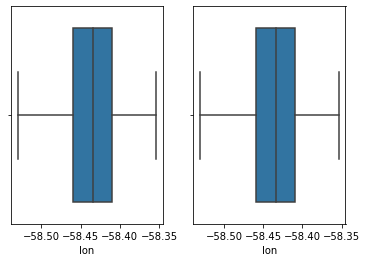

Before Removing Outliers
                     After Removing Outliers


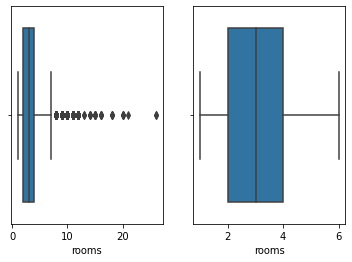

Before Removing Outliers
                     After Removing Outliers


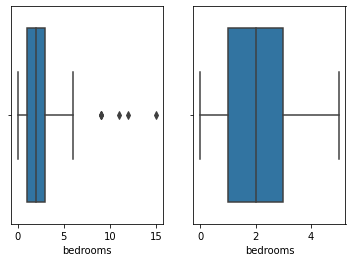

Before Removing Outliers
                     After Removing Outliers


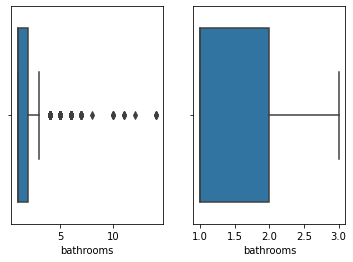

Before Removing Outliers
                     After Removing Outliers


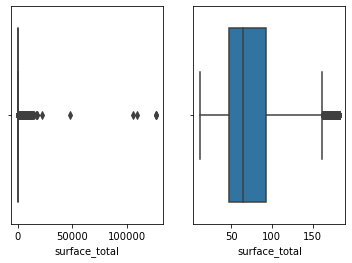

Before Removing Outliers
                     After Removing Outliers


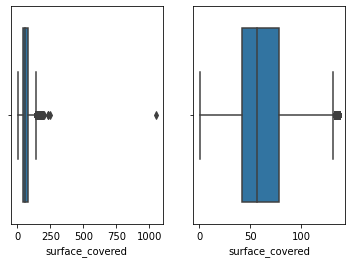

Before Removing Outliers
                     After Removing Outliers


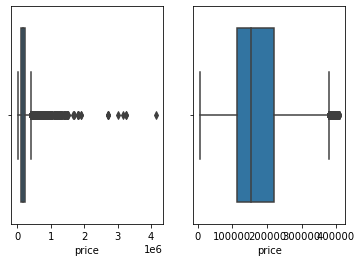

In [15]:
properati_outliers=remove_outliers(properati_dummies)

In [16]:
print('Cantidad de instancias antes:', properati_dummies.shape[0])
print('Cantidad de instancias despues:', properati_outliers.shape[0])

Cantidad de instancias antes: 91485
Cantidad de instancias despues: 75337


## Imputacion de valores faltantes

In [17]:
imputer=KNNImputer(n_neighbors=5, weights= 'uniform')
properati_impute_done = imputer.fit_transform(properati_outliers)

In [18]:
properati_ready=pd.DataFrame(properati_impute_done,columns=properati_outliers.columns)

In [19]:
properati_ready

lat        lon  rooms  bedrooms  bathrooms  surface_total  \
0     -34.624056 -58.412110    2.0       1.0        2.0           70.0   
1     -34.593569 -58.427474    2.0       1.0        1.0           45.0   
2     -34.581294 -58.436754    2.0       1.0        1.0           85.0   
3     -34.593779 -58.441239    2.0       1.0        1.0           56.0   
4     -34.600988 -58.433061    2.0       1.0        1.0           70.0   
...          ...        ...    ...       ...        ...            ...   
75332 -34.578688 -58.435533    2.0       1.0        1.0           80.0   
75333 -34.581699 -58.433547    3.0       2.0        2.0           85.0   
75334 -34.581425 -58.442707    3.0       2.0        2.0           88.0   
75335 -34.576573 -58.434394    3.0       2.0        1.0           84.0   
75336 -34.569872 -58.430909    5.0       2.0        2.0          114.0   

       surface_covered     price  property_type_Casa  \
0                 58.0  159000.0                 0.0   
1                 45.0  125000.0                 0.0   
2                 50.0  295000.0                 0.0   
3                 56.0  150000.0                 0.0   
4                 70.0  159500.0                 0.0   
...                ...       ...                 ...   
75332             80.0  170000.0                 0.0   
75333             81.0  225000.0                 0.0   
75334             82.0  399000.0                 0.0   
75335             84.0  178000.0                 0.0   
75336             95.0  298000.0                 0.0   

       property_type_Departamento  property_type_PH  
0                             0.0               1.0  
1                             0.0               1.0  
2                             0.0               1.0  
3                             0.0               1.0  
4                             0.0               1.0  
...                           ...               ...  
75332                         1.0               0.0  
75333                         1.0               0.0  
75334                         1.0               0.0  
75335                         0.0               1.0  
75336                         0.0               1.0  

[75337 rows x 11 columns]

In [20]:
properati_ready.isna().sum()

lat                           0
lon                           0
rooms                         0
bedrooms                      0
bathrooms                     0
surface_total                 0
surface_covered               0
price                         0
property_type_Casa            0
property_type_Departamento    0
property_type_PH              0
dtype: int64

### Escalado de los datos

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))

def scaleColumns(df, cols_to_scale):
        
    for col in cols_to_scale:
        
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
    
    return df

In [22]:
properati_ready_escaled=scaleColumns(properati_ready,['lat','lon','rooms','bedrooms','bathrooms','surface_total','surface_covered','price'])

In [23]:
properati_escaled=pd.DataFrame(properati_ready_escaled,columns=properati_ready.columns)

In [24]:
properati_escaled=properati_escaled.rename(columns={"property_type_Casa":"casa","property_type_Departamento":"departamento","property_type_PH":"PH"})

In [25]:
properati_escaled

lat       lon  rooms  bedrooms  bathrooms  surface_total  \
0      0.450834  0.670438    0.2       0.2        0.5       0.341176   
1      0.640770  0.583409    0.2       0.2        0.0       0.194118   
2      0.717244  0.530842    0.2       0.2        0.0       0.429412   
3      0.639461  0.505438    0.2       0.2        0.0       0.258824   
4      0.594548  0.551759    0.2       0.2        0.0       0.341176   
...         ...       ...    ...       ...        ...            ...   
75332  0.733482  0.537756    0.2       0.2        0.0       0.400000   
75333  0.714724  0.549007    0.4       0.4        0.5       0.429412   
75334  0.716426  0.497120    0.4       0.4        0.5       0.447059   
75335  0.746657  0.544209    0.4       0.4        0.0       0.423529   
75336  0.788407  0.563952    0.8       0.4        0.5       0.600000   

       surface_covered     price  casa  departamento   PH  
0             0.419118  0.379224   0.0           0.0  1.0  
1             0.323529  0.294118   0.0           0.0  1.0  
2             0.360294  0.719650   0.0           0.0  1.0  
3             0.404412  0.356696   0.0           0.0  1.0  
4             0.507353  0.380476   0.0           0.0  1.0  
...                ...       ...   ...           ...  ...  
75332         0.580882  0.406758   0.0           1.0  0.0  
75333         0.588235  0.544431   0.0           1.0  0.0  
75334         0.595588  0.979975   0.0           1.0  0.0  
75335         0.610294  0.426783   0.0           0.0  1.0  
75336         0.691176  0.727159   0.0           0.0  1.0  

[75337 rows x 11 columns]

En este punto finaliza el pre-procesamiento de los datos del dataset original

## Arbol de decision - Benchmark

Este modelo fue utilizado en el proyecto 1:

In [26]:
X=properati_escaled[['lat','lon','rooms','bedrooms','bathrooms','surface_total','surface_covered','casa','departamento','PH']]
y=properati_escaled.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
def tree_rmse():
    
    # Definimos las listas vacias para los valores de rmse deseados
    list_rmse_train = []
    list_rmse_test = []

    # Definimos la lista de valores de max_depth que vamos a explorar
    max_depths = [1,2,3,4,5,6,7,8,9,10,12,15,20,25]

    # Inicializamos valores para almacer el valor del parámetro de profundidad que obtiene
    # el menor rmse_test

    rmse_min_tree = 1000000
    i_min_tree = 0

    # Generamos en loop sobre los distintos valores de profundidad 
    for i in max_depths:
         
        # Definir el modelo con el valor de profundidad a iterar
        tree = DecisionTreeRegressor(max_depth=i, random_state=42)
    
        # Entrenar el modelo
        tree.fit(X_train, y_train)
    
        # Predecir y evaluar sobre el set de entrenamiento
        y_train_pred_tree= tree.predict(X_train)
        rmse_train_tree = np.sqrt(mean_squared_error(y_train, y_train_pred_tree))
    
        # Predecir y evaluar sobre el set de evaluación
        y_test_pred_tree= tree.predict(X_test)
        rmse_test_tree = np.sqrt(mean_squared_error(y_test, y_test_pred_tree))

        if (rmse_test_tree < rmse_min_tree) and ( (rmse_train_tree / rmse_test_tree ) > 0.8 ):
        
            rmse_min_tree = rmse_test_tree
            i_min_tree = i 
    
        # Agregar la información a las listas
        list_rmse_train.append(rmse_train_tree)
        list_rmse_test.append(rmse_test_tree)
    
    plt.plot(max_depths,list_rmse_train,'o-',label='train' )
    plt.plot(max_depths,list_rmse_test,'o-',label='test')
    plt.legend()
    plt.xlabel('Profundidad del árbol')
    plt.ylabel('Exactitud')
    
    print(f'La profundidad del árbol óptima para minimizar el RMSE es: {i_min_tree}')
    print(f'El RMSE correspondiente a esa profundidad del arbol: {rmse_min_tree}')
    
    return i_min_tree,rmse_min_tree

La profundidad del árbol óptima para minimizar el RMSE es: 12
El RMSE correspondiente a esa profundidad del arbol: 0.08549254883748453


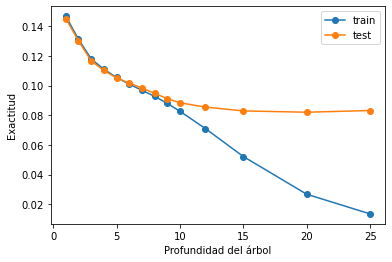

In [28]:
(i_min_tree,rmse_min_tree) = tree_rmse()

## Random Forest

In [29]:
#clf = RandomForestRegressor() Dejo esta opcion para correr el modelo con los parametros por default
clf = RandomForestRegressor(n_estimators=100, max_features='sqrt', n_jobs=-1, oob_score = True, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf.fit(X_train,y_train)

RandomForestRegressor(max_features='sqrt', n_jobs=-1, oob_score=True,
                      random_state=42)

In [30]:
y_pred= clf.predict(X_test)

In [31]:
RMSE_rf= np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (RMSE_rf))

RMSE: 0.061578


In [32]:
#Calcula R^2 , que es una forma de indicar qué tan bien el modelo explica los datos.
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9830811539095813
0.8990670247214522


In [33]:
clf.feature_importances_

array([0.16565665, 0.09422328, 0.06228826, 0.03723087, 0.08561122,
       0.28846066, 0.251293  , 0.00125728, 0.00663987, 0.00733891])

C:\Users\Christian\miniconda3\envs\datascience\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


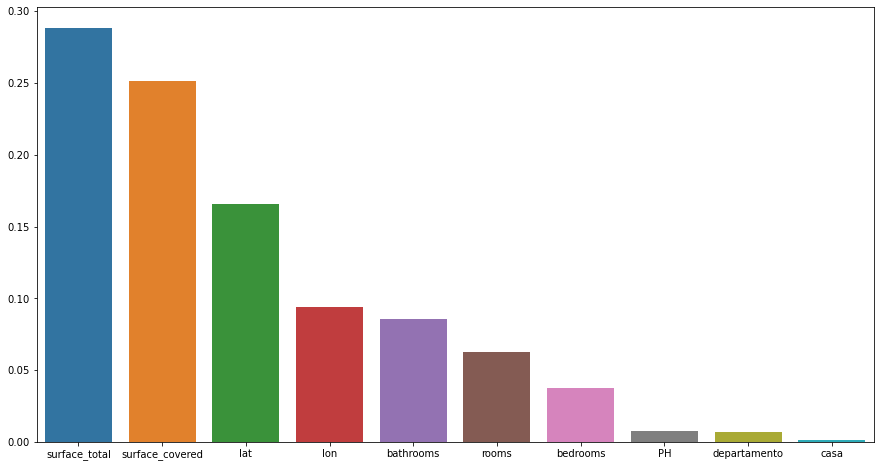

In [34]:
importances = clf.feature_importances_
columns = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize = (15,8))
sns.barplot(columns[indices], importances[indices])
plt.show()

Este grafico nos da una medida de la importancia de cada feature en la prediccion

In [35]:
clf_tree = clf.estimators_[50]
clf_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 1224821422,
 'splitter': 'best'}

In [36]:
n_estimators = [60, 70, 80]
max_depth = [25 , 30]
max_features = [3, 4, 5]

param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)

param_grid

{'n_estimators': [60, 70, 80],
 'max_depth': [25, 30],
 'max_features': [3, 4, 5]}

In [37]:
%%time
clf_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=2, scoring='r2', verbose=1)
clf_rf.fit(X_train,y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  2.6min finished


Wall time: 2min 40s


GridSearchCV(cv=2, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [25, 30], 'max_features': [3, 4, 5],
                         'n_estimators': [60, 70, 80]},
             scoring='r2', verbose=1)

In [38]:
y_pred= clf_rf.predict(X_test)

In [39]:
RMSE_rf_gs= np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (RMSE_rf_gs))

RMSE: 0.061468


In [40]:
clf_rf.best_estimator_

RandomForestRegressor(max_depth=30, max_features=4, n_estimators=80)

In [41]:
print(clf_rf.score(X_train, y_train))
print(clf_rf.score(X_test, y_test))

0.9829181914034478
0.8994266495361394


## XGBoost

In [42]:
# Hiperparametros de XGBoost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', eval_metric= 'rmse',colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [43]:
xg_reg.fit(X_train,y_train)
y_pred_xgb = xg_reg.predict(X_test)

In [44]:
RMSE_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("RMSE: %f" % (RMSE_xgb))

RMSE: 0.136323


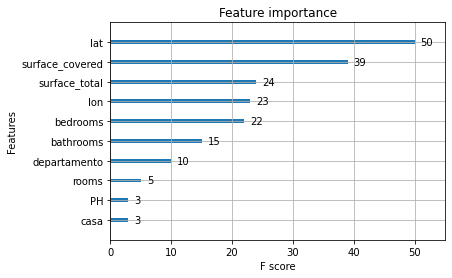

In [45]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [6, 6]
plt.show()

Este grafico nos da una medida de la importancia de cada feature en la prediccion

In [46]:
n_estimators = [ 20, 30 ] 
learning_rate = [0.1 , 0.05] 
max_depth =  [12, 15] 

param_grid_xgb = dict(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)

param_grid_xgb

{'n_estimators': [20, 30], 'max_depth': [12, 15], 'learning_rate': [0.1, 0.05]}

In [47]:
clf_xgb = GridSearchCV(xgb.XGBRegressor(), param_grid_xgb, cv=2, scoring='r2', verbose=1)  #verbose: imprime lo que hace en ese momento
clf_xgb.fit(X_train,y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   35.4s finished


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [48]:
y_pred_xgb = clf_xgb.predict(X_test)

In [49]:
RMSE_xgb_gs = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("RMSE: %f" % (RMSE_xgb_gs))

RMSE: 0.066059


In [50]:
clf_xgb.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=30, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9830811539095813
0.8990670247214522


### Compara el desempeño de los nuevos modelos entre sí y con el modelo de la Parte A. ¿Cuál elegirías? Justifica.

In [52]:
table= [['Arbol de decision',rmse_min_tree,'-'],['Random Forest',RMSE_rf,RMSE_rf_gs],['XGBoost',RMSE_xgb, RMSE_xgb_gs]]
print(tabulate(table, headers=['Modelo','RMSE','RMSE con GridSearch'], tablefmt='fancy_grid',numalign="center"))

╒═══════════════════╤═══════════╤═══════════════════════╕
│ Modelo            │   RMSE    │ RMSE con GridSearch   │
╞═══════════════════╪═══════════╪═══════════════════════╡
│ Arbol de decision │ 0.0854925 │ -                     │
├───────────────────┼───────────┼───────────────────────┤
│ Random Forest     │ 0.0615782 │ 0.061468406880910195  │
├───────────────────┼───────────┼───────────────────────┤
│ XGBoost           │ 0.136323  │ 0.06605898712297183   │
╘═══════════════════╧═══════════╧═══════════════════════╛


Utilizando el modelo de la *Parte A*, el cual es un 'Arbol de Decision', se obtuvo un error cuadratico medio de 0,0854. Luego utilicé el modelo conocido con Random Forest, en el cual se obtienen errores similares tanto usando el modelo en si como con la implementacion de combinaciones de hiperparametros conocido como 'GridSearch'. Aqui creo conveniente como sugerencia continuar buscando combinaciones de hiperparametros que mejoren el desempeño del modelo.

Por último, desarrollé el modelo conocido como 'XGBoost'. En el mismo se puede observar la mejora sustancial en el error, mediante la implementacion de la herrramienta GridSearch. 

Entre los modelos evaluados y tomando como referencia de benchmark el modelo de 'Arbol', concluyo que el mejor modelo para realizar la prediccion de los precios de las propiedades en la Capital Federal es el de 'Random Forest' con los siguientes hiperparametros: *[max_depth=30, max_features=5, n_estimators=80]*

#  Interpretacion de modelos

##### Modelo Seleccionado : *'Random Forest'*

- ¿Qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no? 

Mediante el grafico mostrado en el notebook, se puede observar que son 2 features las que tienen mas importancia en la prediccion: superficie total y superficie cubierta, seguidas muy de cerca por la latitud y en menor medida por la longitud, baños, ambientes, habitaciones y el tipo de propiedad. Para la prediccion fueron relevantes 5 variables unicamente: superficie total, superficie cubierta, latitud , longitud y baños. El resto no fueron relevantes para el modelo elegido.

Inicialmente pensé que ahora tomando en cuanta los features del tipo de propiedad, éstos iban a tener mucho mas peso en la prediccion, pero se ha demostrado que esto no fue asi.

* Propuestas de mejora en el modelo elegido

Mejorar la busqueda de hiperparametros con Gridsearch: profundidad de arboles, incrementar el numero de estimadores (el modelo se procesa en poco tiempo, por lo cual se podria llevar a cabo esta aceion sin impactar significativamente en el tiempo de procesamiento) y entrenar el modelo unciamente con aquellas features que pesan mas en la prediccion. 
A nivel dataset, se podria aplicar un balanceo del dataset. Como se vió en el proyecto 1, es mucha mayor la proporcion de datos del barrio de Palermo, respecto a otros barrios. Alli se podria hace un "under-sampling" u "over sampling" del resto de instancias de otros barrios. 

### Analisis dinamico de errores

Armo una funcion para evaluar en Random Forest y XGBoost

In [59]:
def evaluar_regresion(model,X_train, X_test, y_train, y_test):
    plt.figure(figsize = (12,9))

    plt.suptitle(    "Histograma de los errores (price - predicted price)                           Gráfico de dispersión de 'price' vs 'predicted price'", fontsize = 14, color = "b")
    plt.subplot(1,2,1)
    y_train_pred= model.predict(X_train)
    y_pred=model.predict(X_test)
    sns.distplot(y_train - y_train_pred, bins = 30, label = 'train ')
    sns.distplot(y_test - y_pred, bins = 30, label = 'test ')
    plt.xlabel('errores')
    plt.legend()


    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_pred, s =2)
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # minimo de ambos ejes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # maximo de ambos ejes
        ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Valores de dato (test)')
    plt.ylabel('Valores predichos (test)')
    
    plt.tight_layout()
    plt.show()

C:\Users\Christian\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Christian\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


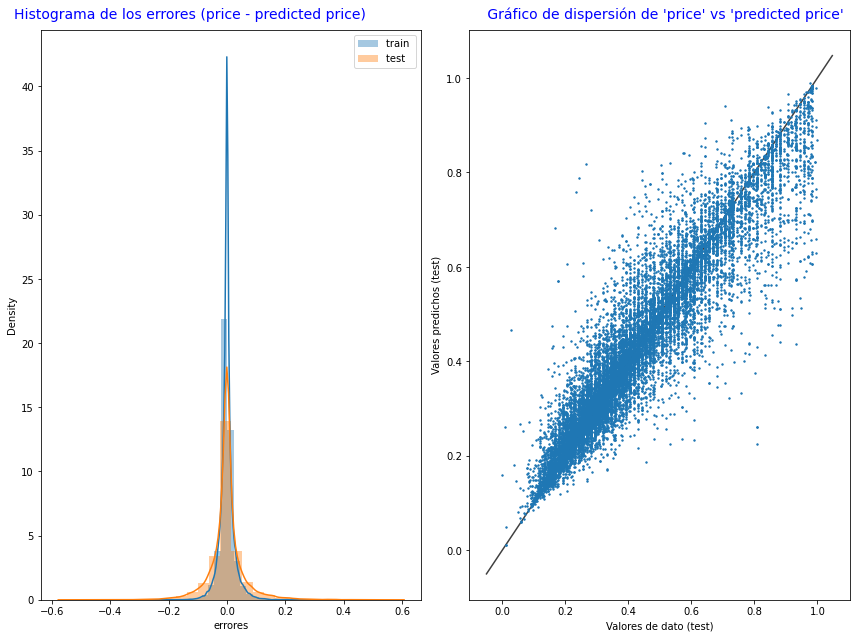

In [60]:
# RandomForest
evaluar_regresion(clf_rf, X_train, X_test, y_train, y_test)

C:\Users\Christian\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Christian\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


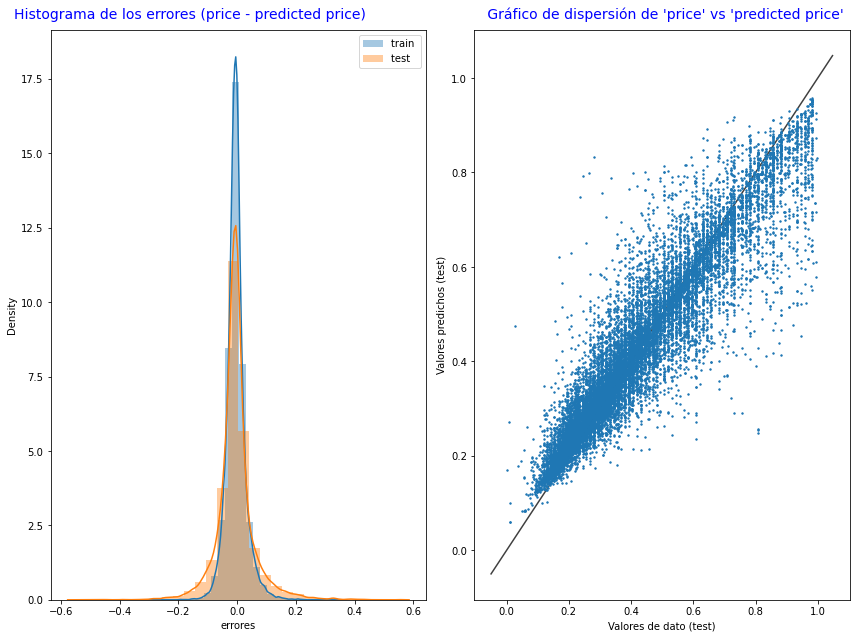

In [61]:
# XGBoost
evaluar_regresion(clf_xgb,X_train, X_test, y_train, y_test)

Conclusiones: se aprecia un mayor error por defecto que por exceso en la prediccion de precios de las propiedades en ambos modelos evaluados. No se visualiza overfitting ni underfitting.